In [26]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.signal import convolve2d
from scipy.optimize import minimize
from scipy.fft import fft2, ifft2, fftshift
from PIL import Image
import time

## Photolithography simulation process and functions

In [1]:
def gaussian_psf(size, sigma):
    """Func for 2D Gaussian PSF"""
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    psf_out = psf / np.sum(psf)
    return psf_out

def optical_model(mask, psf):
    """Func to calc light intensity on the photoresist using PSF."""
    model_out = np.abs(convolve2d(mask, psf, mode='same')) ** 2
    return model_out


def photoresist_model(intensity, threshold, a_r):
    """Func to calc resist pattern based on the light intensity."""
    resist_out = 1 / (1 + np.exp(-a_r * (intensity - threshold)))
    return resist_out

def cost_function(mask_flat, target_layout, psf, threshold, a_r):
    """Func to calc cost between the target layout and the resist pattern."""
    mask = mask_flat.reshape(target_layout.shape)
    intensity = optical_model(mask, psf)
    resist_pattern = photoresist_model(intensity, threshold, a_r)
    cost_out = np.linalg.norm(target_layout - resist_pattern)**2
    return cost_out

def optimize_mask(target_layout, initial_mask, psf, threshold, a_r):
    """Func to optimizes mask layout to get ILT mask"""
    initial_mask_flat = initial_mask.flatten()
    result = minimize(cost_function, initial_mask_flat, 
                      args=(target_layout, psf, threshold, a_r),
                      bounds=[(0, 1)] * len(initial_mask_flat),
                      method='Powell') 
    
    optimized_mask_flat = result.x
    optimized_mask_out = optimized_mask_flat.reshape(target_layout.shape)
    return optimized_mask_out

def import_and_preprocess_image(file_path, pixels):
    """Import image and preprocesses"""
    crop_size = 0.15
    image = Image.open(file_path)
    width, height = image.size
    image = image.crop((width*crop_size, 
                        height*crop_size, 
                        width*(1-crop_size), 
                        height*(1-crop_size)))
    image = image.resize((pixels, pixels)).convert('L')
    img_out = np.asarray(image) / 255.0
    return img_out


## Pixel comparison

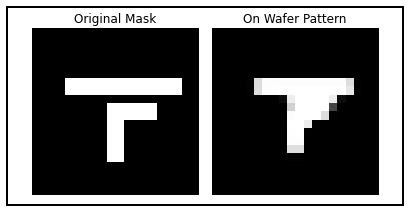

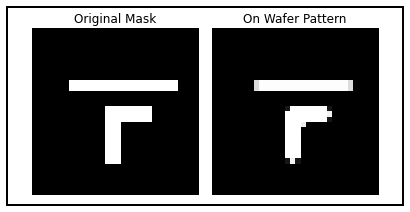

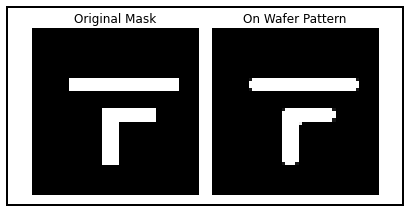

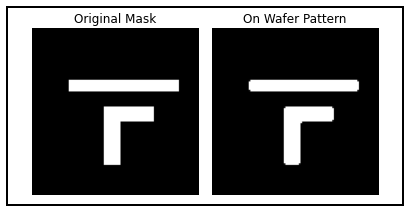

In [27]:
for j in [20,32,50,100]:
    i = 33
    file_name = f"test_{i:02}.png"  
    file_path = f"random_pattern/{file_name}"
    pixels = j
    mask = import_and_preprocess_image(file_path, pixels=pixels)
    name = 'Original Mask'

    fig = plt.figure(figsize=(5, 2.5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    psf = gaussian_psf(5, 1.2) 
    threshold = 0.25
    a_r = 50
    intensity = optical_model(mask, psf)
    resist_pattern = photoresist_model(intensity, threshold, a_r)

    ax1.imshow(mask, cmap='gray')
    ax1.set_title(name)
    ax1.axis('off')  
    ax2.imshow(resist_pattern, cmap='gray')
    ax2.set_title('On Wafer Pattern')
    ax2.axis('off') 

    plt.tight_layout(pad=0.1)  
    border_width = 2  
    rect = patches.Rectangle((-0.05, -0.05), 1.1, 1.1, transform=fig.transFigure, 
                          clip_on=False, linewidth=border_width, edgecolor='k', facecolor='none')
    fig.patches.append(rect)  

    plt.show()

## ILT Mask Data Generation from "random_pattern" Mask Features Dataset
#### This step takes multiple hours (~11 minutes per mask), the specific images from the "random_pattern" dataset can be selected in the selection variable. Adjust this variable accordingly. 

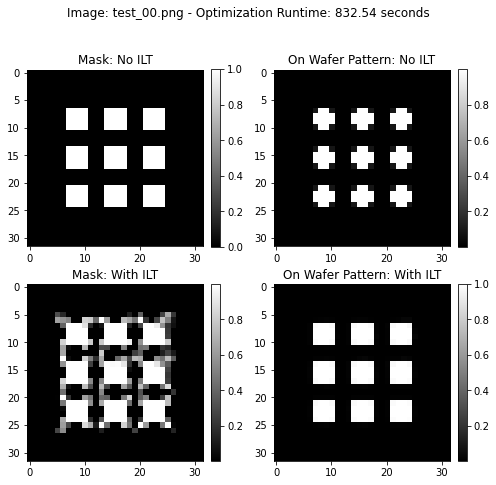

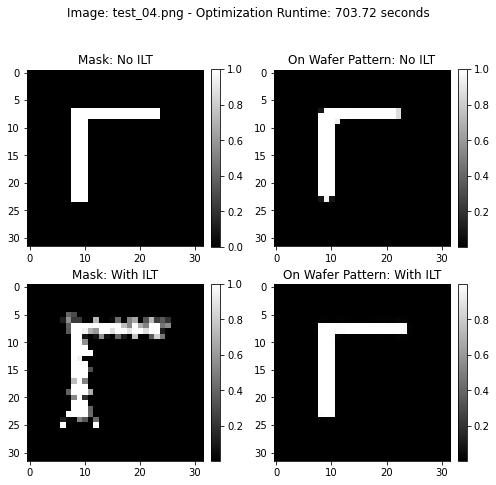

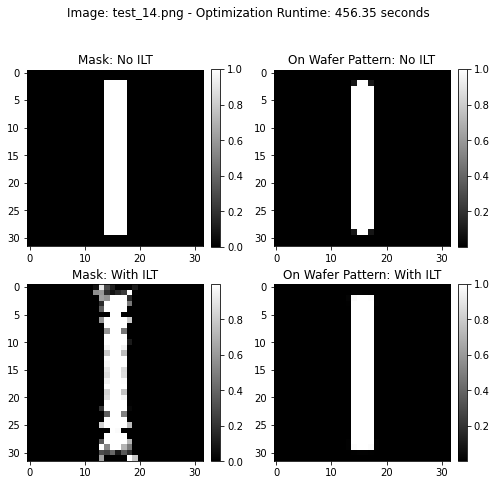

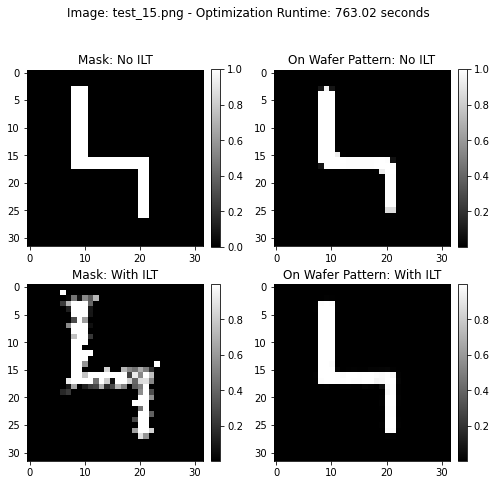

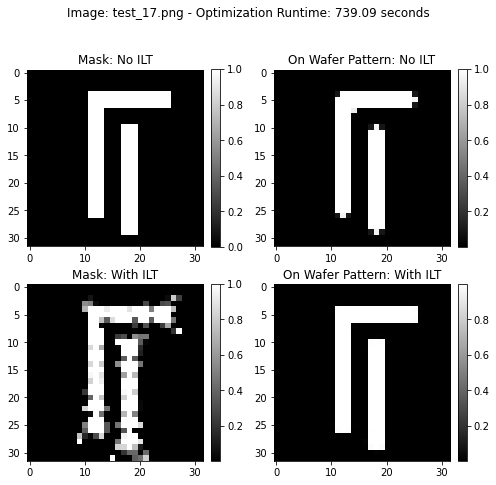

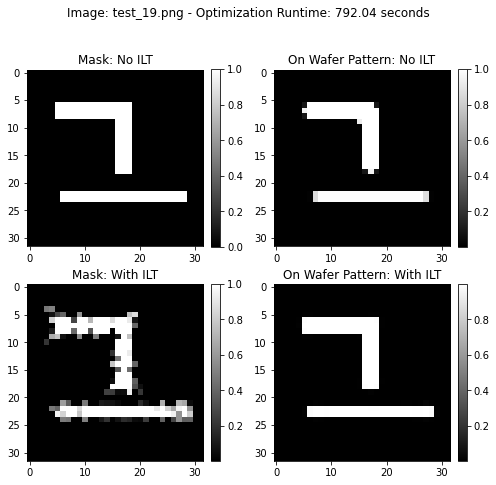

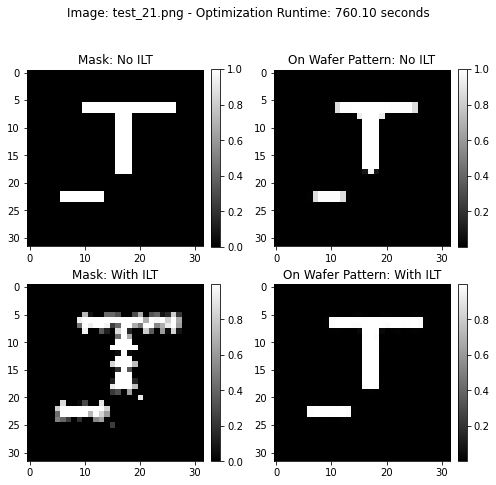

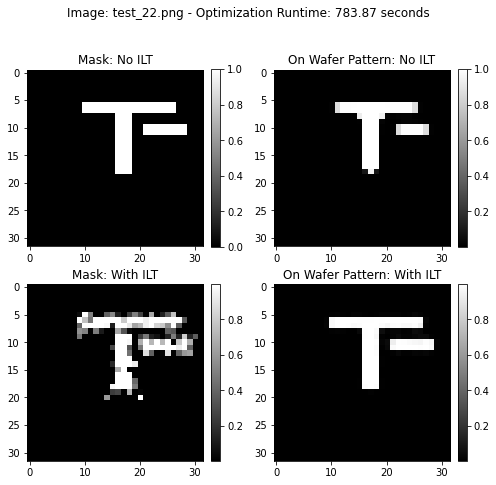

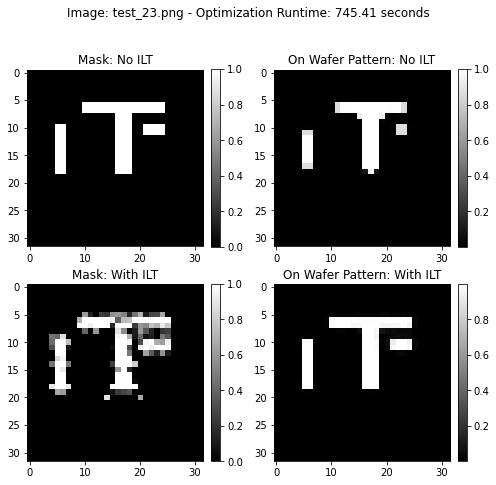

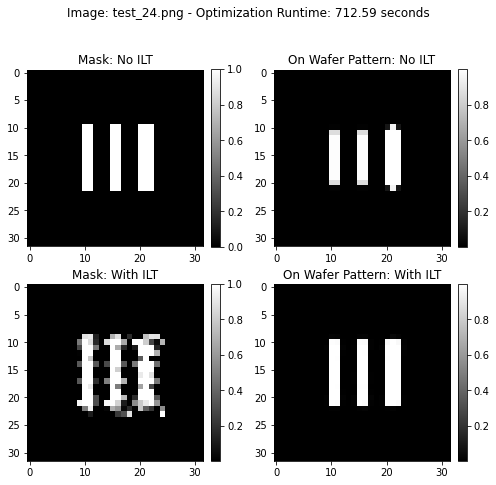

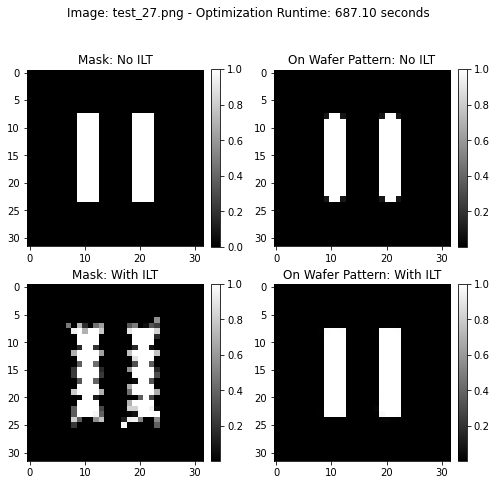

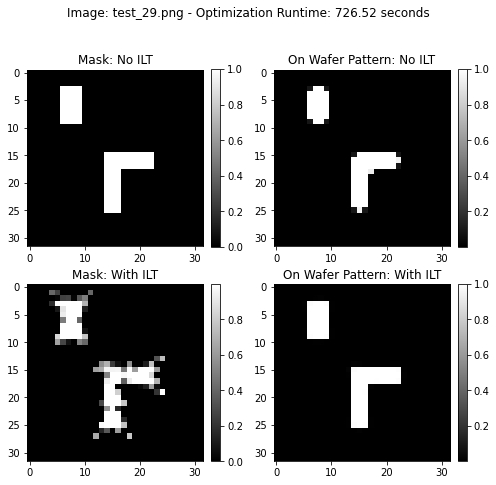

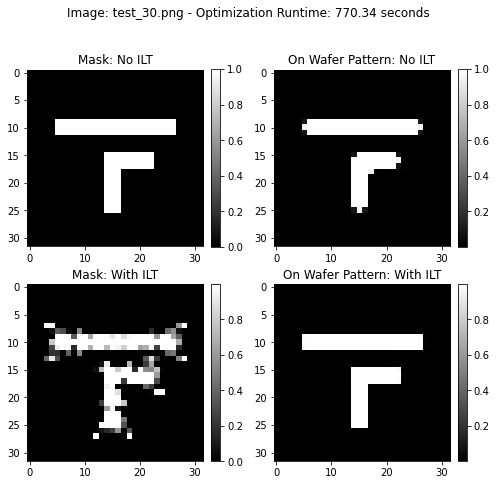

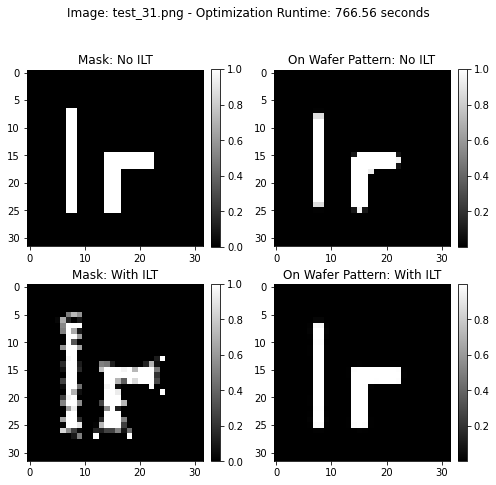

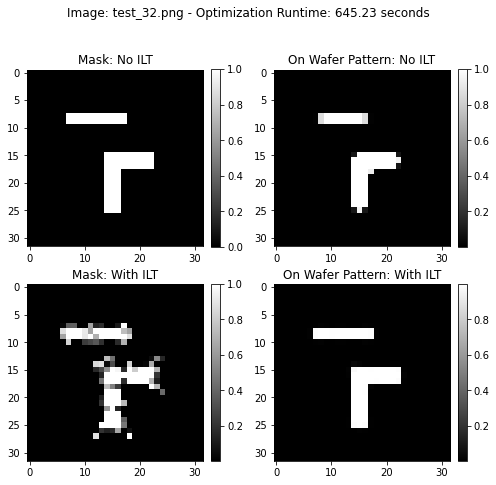

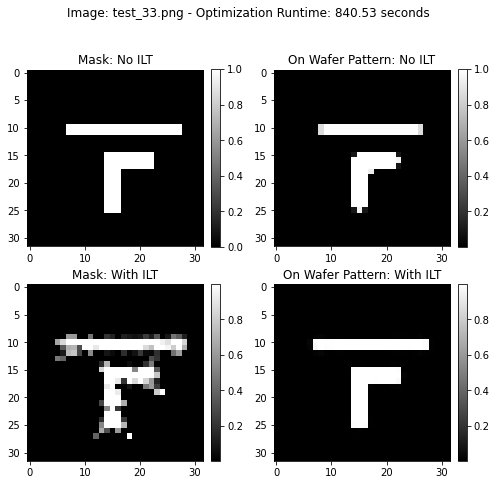

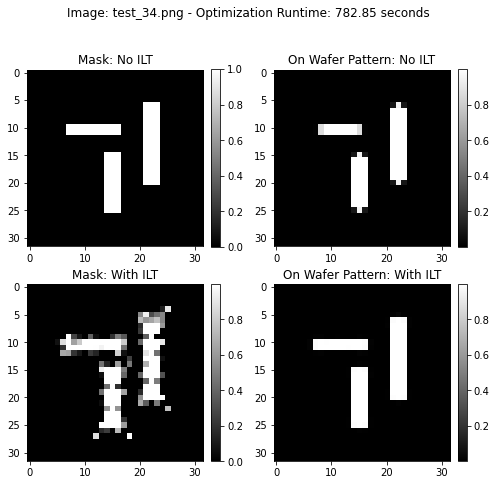

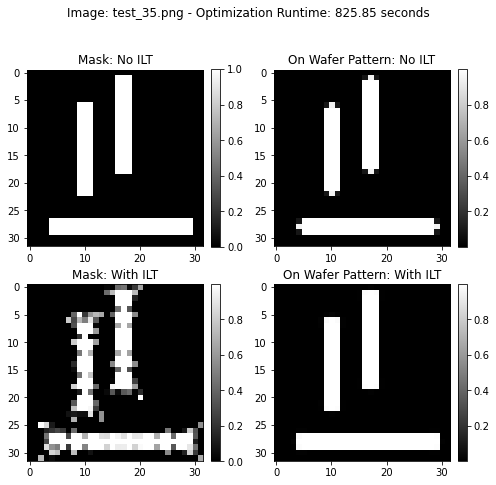

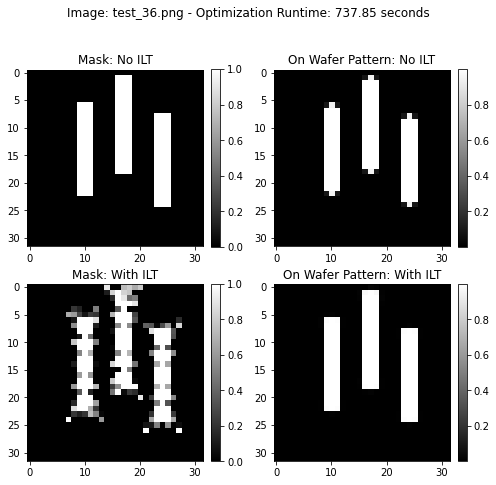

In [11]:
selection = [0,4,14,15,17,19,21,22,23,24,27,29,30,31,32,33,34,35,36]

for i in selection:  
    file_name = f"test_{i:02}.png" 
    file_path = f"random_pattern/{file_name}"
    pixels = 32
    target_layout = import_and_preprocess_image(file_path, pixels=pixels)
    initial_mask = np.random.rand(pixels, pixels)
    psf = gaussian_psf(5, 1.2)
    threshold = 0.25
    a_r = 50

    start_time = time.time()
    optimized_mask = optimize_mask(target_layout, initial_mask, psf, threshold, a_r)
    end_time = time.time()
    runtime = end_time - start_time

    plt.imsave(f"optimised_masks_2/optimized_{file_name}", optimized_mask, cmap='gray')

    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    fig.suptitle(f"Image: {file_name} - Optimization Runtime: {runtime:.2f} seconds")

    for j, (mask, name) in enumerate(zip([target_layout, optimized_mask], ['No ILT', 'With ILT'])):
        intensity = optical_model(mask, psf)
        resist_pattern = photoresist_model(intensity, threshold, a_r)
        
        # Plot for the mask
        ax = axs[j, 0]
        mask_plot = ax.imshow(mask, cmap='gray')
        ax.set_title('Mask: ' + name)
        fig.colorbar(mask_plot, ax=ax, fraction=0.046, pad=0.04)

        # Plot for the on wafer pattern
        ax = axs[j, 1]
        resist_plot = ax.imshow(resist_pattern, cmap='gray')
        ax.set_title('On Wafer Pattern: ' + name)
        fig.colorbar(resist_plot, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
